Enter your Alpha Vantage API key here: KQKQYIYD2CYSYOKV
Enter the stock symbol (e.g., AAPL for Apple Inc.): AMZN
Enter temporal resolution (e.g., TIME_SERIES_INTRADAY, TIME_SERIES_DAILY): TIME_SERIES_INTRADAY
Enter output parameter (e.g., compact, full): full
Enter desired interval parameter (e.g., 1min, 5min, 15min, 30min, 60min): 5min
               Timestamp     Open      High     Low   Close  Volume
0    2024-10-16 19:55:00  186.660  186.6600  186.51  186.65    6086
1    2024-10-16 19:50:00  186.655  186.7361  186.56  186.61    1576
2    2024-10-16 19:45:00  186.730  186.7500  186.63  186.70    1133
3    2024-10-16 19:40:00  186.660  186.7500  186.55  186.65     656
4    2024-10-16 19:35:00  186.750  186.7500  186.51  186.57     984
...                  ...      ...       ...     ...     ...     ...
4218 2024-09-17 04:20:00  185.500  185.5900  185.45  185.57     383
4219 2024-09-17 04:15:00  185.440  185.5900  185.43  185.50     993
4220 2024-09-17 04:10:00  185.350  185.5400  185.

/Users/gracehuang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gracehuang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gracehuang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gracehuang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:15

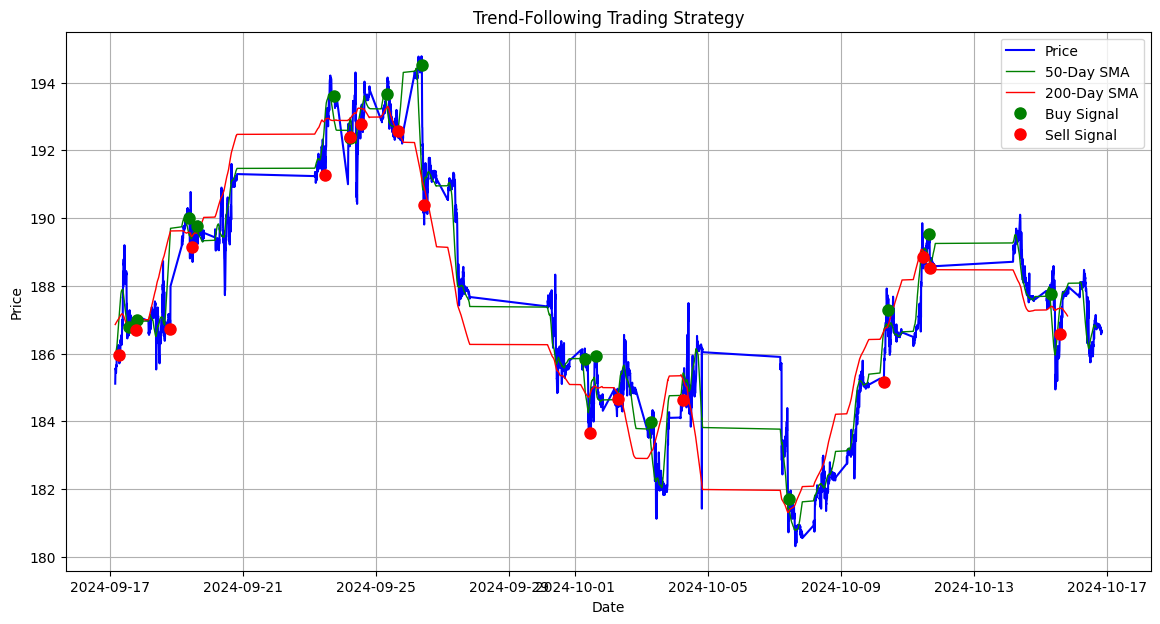

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Set your Alpha Vantage API key here
api_key = input( 'Enter your Alpha Vantage API key here: ' )
# Stock symbol to fetch data for (e.g., 'AAPL' for Apple Inc.)
symbol = input('Enter the stock symbol (e.g., AAPL for Apple Inc.): ')
# other variables
timeseries = input('Enter temporal resolution (e.g., TIME_SERIES_INTRADAY, TIME_SERIES_DAILY): ')
output = input('Enter output parameter (e.g., compact, full): ')

if timeseries == 'TIME_SERIES_INTRADAY':
    interval = input('Enter desired interval parameter (e.g., 1min, 5min, 15min, 30min, 60min): ')
    endpoint = f'https://www.alphavantage.co/query?function={timeseries}&symbol={symbol}&outputsize={output}&interval={interval}&apikey={api_key}'
else:
    endpoint = f'https://www.alphavantage.co/query?function={timeseries}&symbol={symbol}&outputsize={output}&apikey={api_key}'

# Make an API request to fetch real-time stock data from Alpha Vantage
response = requests.get(endpoint).json()

# Accessing MetaData fields
metadata = response['Meta Data']
symbol = metadata['2. Symbol']
lastRefreshed = metadata['3. Last Refreshed']

# Accessing TimeSeries fields
if timeseries == 'TIME_SERIES_INTRADAY':
    timeSeries = response[f'Time Series ({interval})']
elif timeseries == 'TIME_SERIES_DAILY':
    timeSeries = response['Time Series (Daily)']

# Initialize lists to store data
timestamps = []
openPrices = []
highPrices = []
lowPrices = []
closePrices = []
volumes = []

# Loop through each timestamp and extract data fields
for timestamp, data in timeSeries.items():
    if timeseries == 'TIME_SERIES_INTRADAY':
        timestamp_dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    else:
        timestamp_dt = datetime.strptime(timestamp, '%Y-%m-%d')
    
    timestamps.append(timestamp_dt)
    openPrices.append(float(data['1. open']))
    highPrices.append(float(data['2. high']))
    lowPrices.append(float(data['3. low']))
    closePrices.append(float(data['4. close']))
    volumes.append(int(data['5. volume']))

# Create a DataFrame with timestamps and extracted data
stockData = pd.DataFrame({
    'Timestamp': timestamps,
    'Open': openPrices,
    'High': highPrices,
    'Low': lowPrices,
    'Close': closePrices,
    'Volume': volumes
})

print(stockData)

# Algorithmic Trading Strategy
shortTermSMA = 50  # 50-day short SMA
longTermSMA = 200  # 200-day long SMA

# Calculate SMAs
shortSMA = stockData['Close'].rolling(window=shortTermSMA).mean()
longSMA = stockData['Close'].rolling(window=longTermSMA).mean()

# Initialize trading signals
signals = np.zeros(len(stockData))  # 0 is no signal, 1 is buy, -1 is sell

# Generate trading signals based on crossover strategy
for i in range(longTermSMA, len(stockData)):
    if shortSMA[i] > longSMA[i] and shortSMA[i - 1] <= longSMA[i - 1]:
        signals[i] = 1  # Buy signal
    elif shortSMA[i] < longSMA[i] and shortSMA[i - 1] >= longSMA[i - 1]:
        signals[i] = -1  # Sell signal

# Backtest the strategy 
initialCapital = float(input('Please enter your initial capital: '))  # Initial capital in USD
capital = initialCapital
position = 0  # Number of shares held

for i in range(len(stockData)):
    if signals[i] == 1:  # Buy signal
        position = capital / stockData['Close'][i]
        capital = 0
    elif signals[i] == -1 and position > 0:  # Sell signal
        capital = position * stockData['Close'][i]
        position = 0

# Calculate final portfolio value
finalValue = capital + (position * stockData['Close'].iloc[-1] if position > 0 else 0)

print(f'Initial Capital: ${initialCapital:.2f}')
print(f'Final Portfolio Value: ${finalValue:.2f}')

# Plot price and moving averages
plt.figure(figsize=(14, 7))

# Convert DataFrame columns to numpy arrays
timestamps_np = stockData['Timestamp'].to_numpy()
closePrices_np = stockData['Close'].to_numpy()
shortSMA_np = shortSMA.to_numpy()
longSMA_np = longSMA.to_numpy()

# Plot price and moving averages using numpy arrays
plt.plot(timestamps_np, closePrices_np, label='Price', color='blue', linewidth=1.5)
plt.plot(timestamps_np, shortSMA_np, label=f'{shortTermSMA}-Day SMA', color='green', linewidth=1)
plt.plot(timestamps_np, longSMA_np, label=f'{longTermSMA}-Day SMA', color='red', linewidth=1)

# Plot buy/sell signals using numpy arrays
buySignals = closePrices_np[signals == 1]
sellSignals = closePrices_np[signals == -1]
plt.plot(timestamps_np[signals == 1], buySignals, 'go', markersize=8, label='Buy Signal')
plt.plot(timestamps_np[signals == -1], sellSignals, 'ro', markersize=8, label='Sell Signal')

plt.title('Trend-Following Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()